# Analysis of Portuguese news

## Imports

In [67]:
#Data manipulation and visualization libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import seaborn as sns
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator

#NLP-related libraries
import spacy
from spacy.lang.pt import Portuguese
import nltk
from LeIA import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from chromadb import PersistentClient, Settings
from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

#Statistic tools
from scipy import stats
from scipy.spatial import distance
from statsmodels.tsa.seasonal import seasonal_decompose

#File integration
import json
from utils import pt_stopwords, tokenizer, vectorizer, get_embedding, label_score, colormap_rdylgn, polarizer

#OpenAI integration libraries
import tiktoken
from openai import OpenAI

#Other libraries
import time
import datetime
import urllib.request
import sys
import codecs
import csv

#Load the configuration from a config.json
with open("config.json", "r") as config_file:
    config = json.load(config_file)

#Pathnames
dir = config["dir"]
filename = dir + config["data"]["news"]
png = dir + config["pictures"]["input"]["input_pt_map"]
wordcloud = dir + config["pictures"]["output"]["output_pt_map"]
sentiment_avg = dir + config["pictures"]["output"]["output_sentiment"]
proportion_per_category = dir + config["pictures"]["output"]["output_proportions"]
daily_sentiment = dir + config["pictures"]["output"]["output_daily"]
political_party_sentiment = dir + config["pictures"]["output"]["output_political_party_sentiment"]
soccer_club_number_of_news = dir + config["pictures"]["output"]["output_soccer_club_number_of_news"]
correlation_with_weather = dir + config["pictures"]["output"]["output_correlation_with_weather"]
day_of_week_average_sentiment = dir + config["pictures"]["output"]["output_day_of_week_average_sentiment"]
output_average_sentiment_yearly_trend = dir + config["pictures"]["output"]["output_average_sentiment_yearly_trend"]

#OpenAI api_key and client
api_key = config["api_key"]
client_openai = OpenAI(api_key = api_key)

#Database update flag
update_database = True

In [68]:
#Importing and inspecting DataFrame
unprocessed_news = pd.read_excel(filename)
display(unprocessed_news.head())

#Disabling SettingWithCopyWarning
pd.options.mode.chained_assignment = None

#Deleting empty  cells
news = unprocessed_news.dropna()
print(f"{unprocessed_news.shape[0] - news.shape[0]} row(s) deleted due to missing fields.")
print(f"There are {round((unprocessed_news.shape[0] - news.shape[0])*100/len(news), 2)}% of missing data.")

,date,category,title,description
0,2024-01-16,País,"Polícias mantêm protestos, MAI ""contra-ataca"" ...",O Ministério da Administração Interna responde...
1,2024-01-16,País,"Dez anos depois, engenheiros vão a julgamento ...","O caso remonta a 2013, quando uma derrocada de..."
2,2024-01-16,Meteorologia,Inverno não dá tréguas: IPMA coloca Portugal c...,A depressão Irene chegou ao arquipélago açoria...
3,2024-01-16,Mundo,EUA/Eleições: Donald Trump vence no Iowa com m...,O ex-Presidente dos EUA é o candidato republic...
4,2024-01-16,Economia,Segurança Social começa a pagar abono de famíl...,"Cerca de 1,15 milhões de pessoas deverão ser a..."


216 row(s) deleted due to missing fields.
There are 1.88% of missing data.


## Analysis

### Text Pre-processing

#### Tokenizing text

In [69]:
#Apply tokenization to titles and descriptions
news["title_tokens"] = news["title"].apply(tokenizer)
news["description_tokens"] = news["description"].apply(tokenizer)

#Removing "-se" - Spacy tokenizer limitation with Portuguese language
news["title_tokens"] = news["title_tokens"].str.replace("-se", "")
news["description_tokens"] = news["description"].str.replace("-se", "")

#### Cost control to use OpenAI API

In [70]:
#Opening and empty dictionary
costs = {}

#Establishing variables
cost_per_1k_tokens_embedding_ada = 0.0001
cost_per_1k_tokens_embedding_small = 0.00002
cost_per_1k_tokens_embedding_large = 0.00013
titles = [title for title in news["title"]]
descriptions = [title for title in news["description"]]
models = ["text-embedding-3-small", "text-embedding-3-large", "text-embedding-ada-002"]
cost_per_1k_tokens = [cost_per_1k_tokens_embedding_small, cost_per_1k_tokens_embedding_large, cost_per_1k_tokens_embedding_ada]

#Looping through model/cost to obtain costs
for model, cost in zip(models, cost_per_1k_tokens):
    enc = tiktoken.encoding_for_model(model)
    total_tokens_for_titles = sum(len(enc.encode(text)) for text in titles)
    total_tokens_for_descriptions = sum(len(enc.encode(text)) for text in descriptions)
    costs[model] = [total_tokens_for_titles * cost/ 1000, total_tokens_for_descriptions * cost/ 1000, cost]

#Building a DataFrame to display data
cost_df = pd.DataFrame(costs ,index = ["Titles (USD)", "Descriptions (USD)", "Cost per 1k tokens (USD)"])
display(cost_df)

,text-embedding-3-small,text-embedding-3-large,text-embedding-ada-002
Titles (USD),0.005064,0.032919,0.025322
Descriptions (USD),0.013433,0.087313,0.067164
Cost per 1k tokens (USD),0.000020,0.000130,0.000100


#### Storing data in a Chromadb No-SQL database

In [71]:
#Instantiating a Chromadb client
settings = Settings(allow_reset = True)
client_chromadb = PersistentClient("Analysis-of-Portuguese-news/Data", settings = settings)

#Reset/reindex database if it is to be updated
if update_database:
    client_chromadb.reset()

#Creating a collection if it doesn't exist, else retrieves the existing one
try:
    collection = client_chromadb.create_collection(
        name = "pt_news",
        embedding_function = OpenAIEmbeddingFunction(model_name = "text-embedding-3-large", api_key = api_key)
        )
    print("Collection created successfully")
except:
    print("Collection already exists")
    collection = client_chromadb.get_collection(
        name = "pt_news",
        embedding_function = OpenAIEmbeddingFunction(model_name = "text-embedding-3-large", api_key = api_key)
        )

#Extracting date
timestamps = pd.to_datetime(news["date"])
dates = [time.mktime(date.timetuple()) for date in timestamps]

#Creating a list of concatenated titles and descriptions
fused_titles_descriptions = [title + ". " + description for title, description in zip(titles, descriptions)]

#If update_database variable is set to True
if update_database:
    
    #Looping through concatenated titles and descriptions
    for i, string in enumerate(fused_titles_descriptions):

        #Adding documents to database, embeddings will be created
        collection.upsert(
            ids = [f"news-{1+i}"],
            documents = [string],
            metadatas = {"date": dates[i]})
        print(f"News #{1+i} added to database", end = "\r")
        
#Standardized categories for news articles
labels = [
    "Política nacional e internacional",  
    "Saúde e bem-estar", 
    "Ciência e Tecnologia", 
    "Desporto e competições", 
    "Cultura, Arte e Sociedade", 
    "Finanças e Economia", 
    "Meteorologia e impactos ambientais",
    "Tragédia e desastres",
    "Justiça e Direito",
    "Guerra e conflitos armados",
    "Educação, Ensino e Aprendizagem"]


Collection created successfully


#### Embedding text with OpenAI "text-embedding-3-large" model

In [72]:
#Creating an empty embeddings list
embeddings_openai = []

#Looping through the recently created embeddings and extracting each one
for i in range(len(news)):
    embedding = collection.get(ids = [f"news-{1+i}"], include = ["embeddings"])["embeddings"]
    embeddings_openai.append(embedding)
    print(f"Embedding of news id #{1+i} extracted", end = "\r")

#Creating an embeddings_df
embeddings_openai = np.array(embeddings_openai).reshape(len(embeddings_openai), -1)

#Getting embeddings for every standardized category
label_embeddings_openai = [get_embedding(label, model="text-embedding-3-large") for label in labels]

#Creating a list of best label per embedding
best_score_indexes = [label_score(embedding, label_embeddings_openai) for embedding in embeddings_openai]
labels_openai = [labels[index] for index in best_score_indexes]

#### Embedding text with Spacy's "pt_core_news_lg" model

In [73]:
#Creating an empty embeddings list
embeddings_spacy = [vectorizer(sentence) for sentence in fused_titles_descriptions]
print(f"{len(embeddings_spacy)} embeddings created")

#Getting embeddings for every standardized category
label_embeddings_spacy = [vectorizer(label) for label in labels]

#Creating a list of best label per embedding
best_score_indexes = [label_score(embedding, label_embeddings_spacy) for embedding in embeddings_spacy]
labels_spacy = [labels[index] for index in best_score_indexes]

11490 embeddings created


#### Re-labelling news

In [74]:
#Comparing a sample of 20 news to choose the best labels
categories_df = news[["title", "category"]][0:20]
categories_df["labels_openai"] = labels_openai[0:20]
categories_df["labels_spacy"] = labels_spacy[0:20]
categories_df["human_classified_labels"] = [
    ("Política nacional e internacional", "Finanças e Economia"),
    ("Justiça e Direito", "Tragédia e desastres"),
    "Meteorologia e impactos ambientais",
    "Política nacional e internacional",
    "Finanças e Economia",
    "Desporto e competições",
    "Saúde e bem-estar",
    "Justiça e Direito",
    "Saúde e bem-estar",
    "Finanças e Economia",
    "Cultura, Arte e Sociedade",
    "Desporto e competições",
    "Meteorologia e impactos ambientais",
    ("Educação, Ensino e Aprendizagem", "Cultura, Arte e Sociedade"),
    ("Cultura, Arte e Sociedade", "Meteorologia e impactos ambientais"),
    ("Política nacional e internacional", "Finanças e Economia"),
    ("Política nacional e internacional", "Guerra e conflitos armados", "Finanças e Economia"),
    ("Política nacional e internacional", "Guerra e conflitos armados"),
    ("Tragédia e desastres", "Justiça e Direito"),
    "Cultura, Arte e Sociedade"
    ]

#Showing results
display(categories_df)

,title,category,labels_openai,labels_spacy,human_classified_labels
0,"Polícias mantêm protestos, MAI ""contra-ataca"" ...",País,Finanças e Economia,Política nacional e internacional,"(Política nacional e internacional, Finanças e..."
1,"Dez anos depois, engenheiros vão a julgamento ...",País,Tragédia e desastres,Política nacional e internacional,"(Justiça e Direito, Tragédia e desastres)"
2,Inverno não dá tréguas: IPMA coloca Portugal c...,Meteorologia,Meteorologia e impactos ambientais,Política nacional e internacional,Meteorologia e impactos ambientais
3,EUA/Eleições: Donald Trump vence no Iowa com m...,Mundo,Política nacional e internacional,Política nacional e internacional,Política nacional e internacional
4,Segurança Social começa a pagar abono de famíl...,Economia,Saúde e bem-estar,Política nacional e internacional,Finanças e Economia
5,AS Roma anuncia sucessor de José Mourinho,Desporto,Desporto e competições,Política nacional e internacional,Desporto e competições
6,DGS pondera que a vacinação contra a gripe sej...,Saúde e Bem-estar,Saúde e bem-estar,Política nacional e internacional,Saúde e bem-estar
7,Portugal condenado a pagar mais de 18 mil euro...,País,Justiça e Direito,Política nacional e internacional,Justiça e Direito
8,Corrida à vacina da gripe? Em Lisboa é nos cen...,Saúde e Bem-estar,Saúde e bem-estar,Política nacional e internacional,Saúde e bem-estar
9,Prepare-se para pagar mais (em menus com álcoo...,Economia,Finanças e Economia,Política nacional e internacional,Finanças e Economia


In [75]:
#Calculating accuracy
label_columns = ["labels_openai", "labels_spacy"]
points = []
for column in label_columns:
    condition = categories_df.apply(lambda row: row[column] in row['human_classified_labels'], axis=1)
    points.append(np.where(condition, 1, 0))

print(f"Sample classification accuracy by OpenAI: {round(100*sum(points[0]/len(points[0])))}%")
print(f"Sample classification accuracy by Spacy: {round(100*sum(points[1]/len(points[1])))}%")

Sample classification accuracy by OpenAI: 90%
Sample classification accuracy by Spacy: 30%


In [76]:
#Overwitting news categories
news["category"] = labels_openai

### Creating a Word Cloud

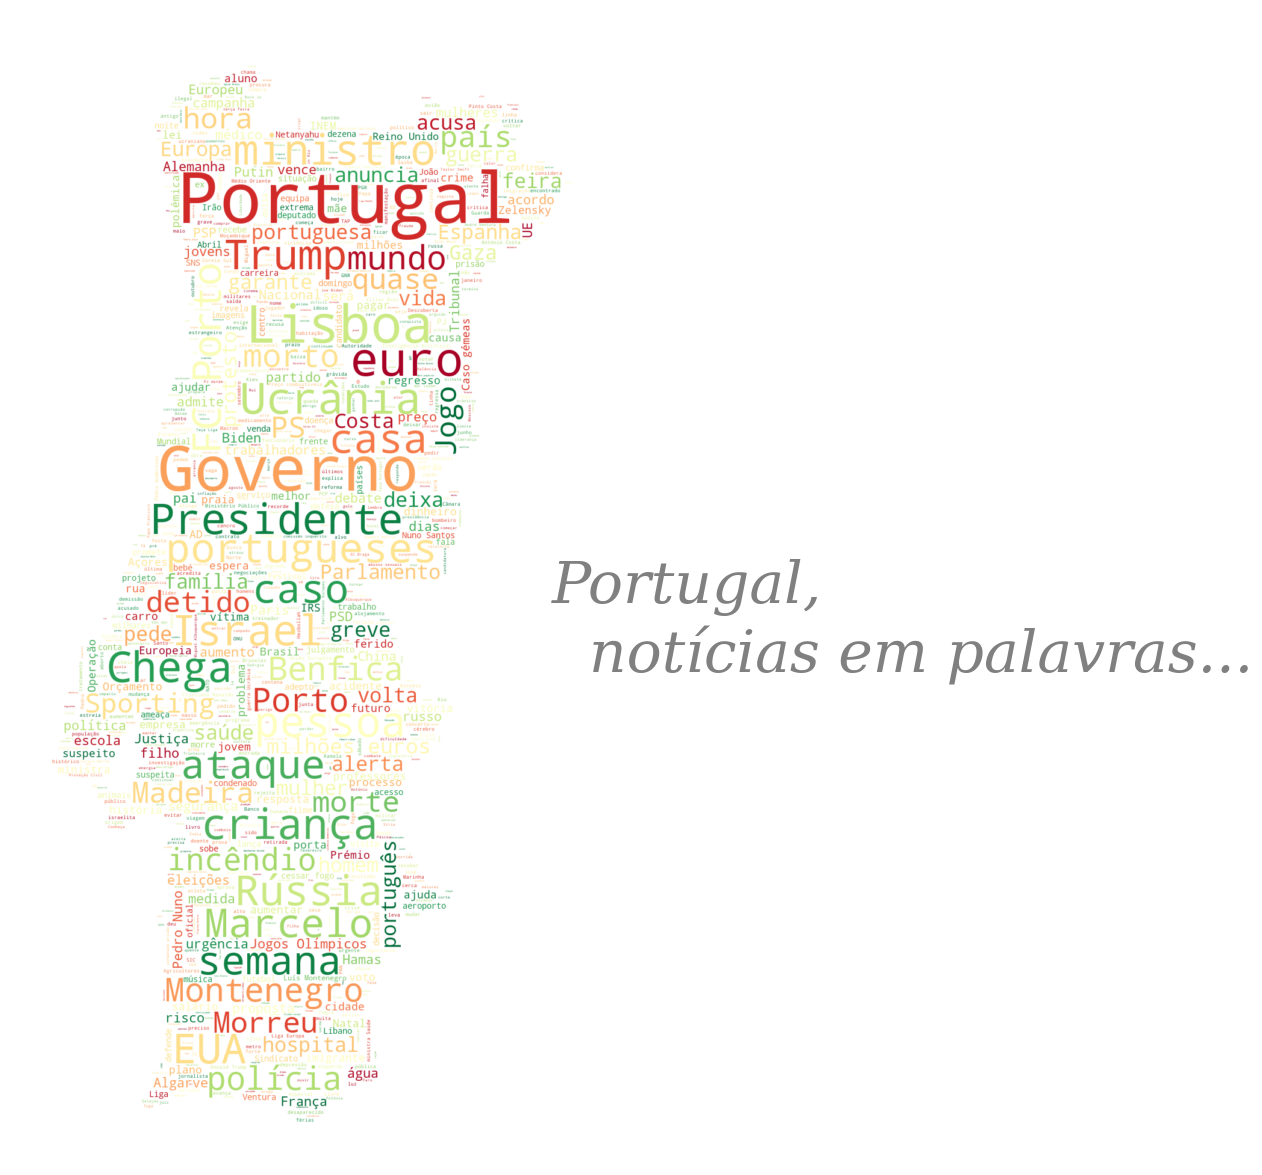

In [78]:
#Building a long title string
title_tokens = [title for title in news["title_tokens"]]
title_tokens = " ".join(title_tokens)

#Convert image to array of 1 and 0
pt_mask = np.array(Image.open(png))
    
#Converting pt_mask array to int32
transformed_pt_mask = np.ndarray((pt_mask.shape[0],pt_mask.shape[1]), np.int32)

#Convert every 0 of the mask, into 255 and apply the transformation to the whole array
for i in range(len(pt_mask)):
    transformed_pt_mask[i] = list(map(lambda val: 255 if val == 0 else val, pt_mask[i]))

#Word Cloud
string_cloud = WordCloud(background_color = "white",
                         max_words = 1000,
                         mask = transformed_pt_mask,
                         colormap = "RdYlGn",
                         stopwords = pt_stopwords).generate(title_tokens)
image_colors = ImageColorGenerator(transformed_pt_mask)
plt.figure(figsize=[20,15])
plt.imshow(string_cloud, interpolation = "bilinear")
plt.axis("off")
plt.text(
    x = 900,
    y = 1100,
    s = "Portugal, \n  notícias em palavras...",
    color = "gray",
    fontsize = 42,
    fontstyle = "italic",
    fontfamily = "serif"
    )
plt.savefig(wordcloud, format="png", dpi=1200)
plt.show()

### Sentiment Analysis

#### Sentiment intensity per category

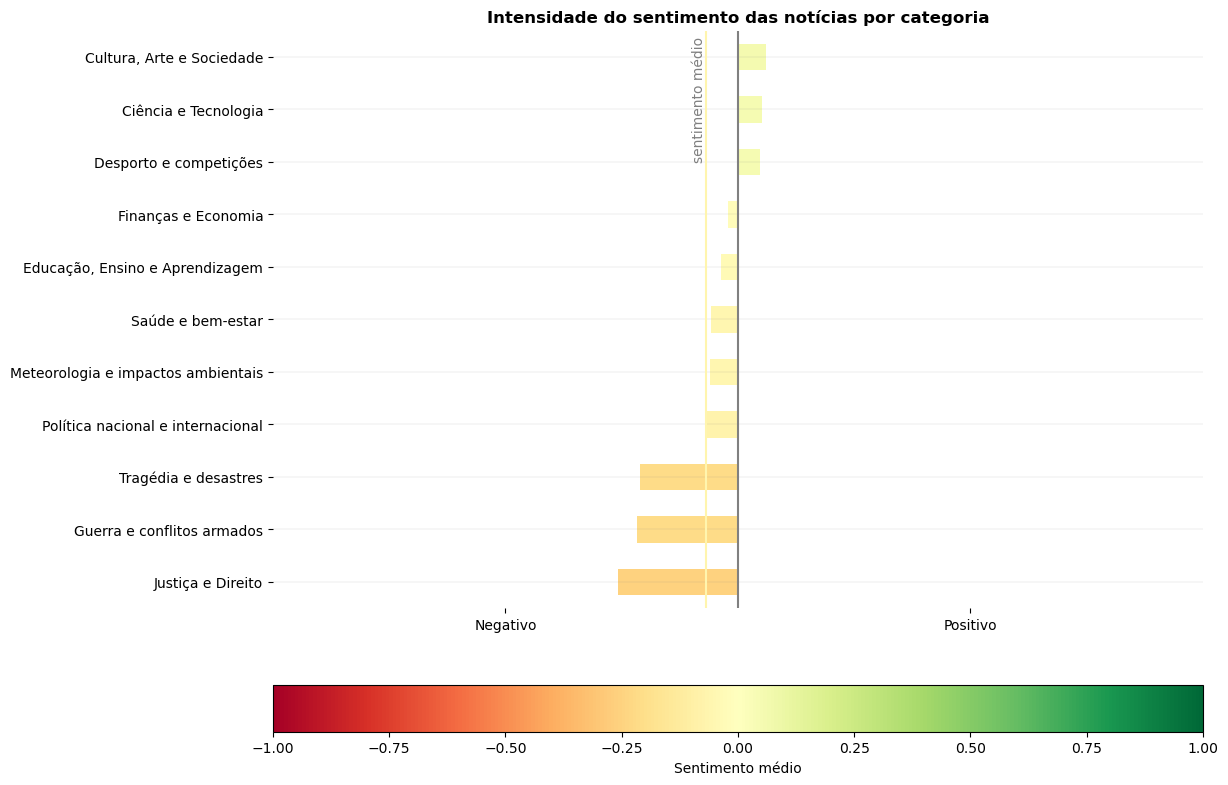

In [79]:
#Applying function to Data frame
news["sentiment"] = news["description"].apply(polarizer)
are_news_that_negative = news.groupby("category")["sentiment"].mean().sort_values()

#Plotting sentiment intensity per news category
ax = are_news_that_negative.plot(kind="barh", color = colormap_rdylgn(are_news_that_negative)[0], figsize=(12, 10))
ax.set_title('Intensidade do sentimento das notícias por categoria', weight = "bold")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xticks([-0.5, 0.5], labels = ["Negativo", "Positivo"])
ax.xaxis.grid(False)
ax.grid(axis = "y", color= "gray", linestyle= "-", linewidth= 0.1)
ax.axvline(0, c = "gray")
ax.axvline(news["sentiment"].mean(), color = colormap_rdylgn(are_news_that_negative, news["sentiment"].mean())[2])
ax.text(
    x = news["sentiment"].mean()
    , y = 0.99
    , s = "sentimento médio"
    , color = "gray"
    , ha = "right"
    , va = "top"
    , rotation = 90
    , transform = ax.get_xaxis_transform())
ax.set_ylabel("")
ax.set_xlim(-1, 1)
cbar = plt.colorbar(colormap_rdylgn(are_news_that_negative)[1], orientation= "horizontal", pad= 0.1, ax= ax)
cbar.set_label("Sentimento médio")
plt.savefig(sentiment_avg, format="png", dpi = 600, bbox_inches = "tight")
plt.show()

#### News proportions per category and their average sentiment

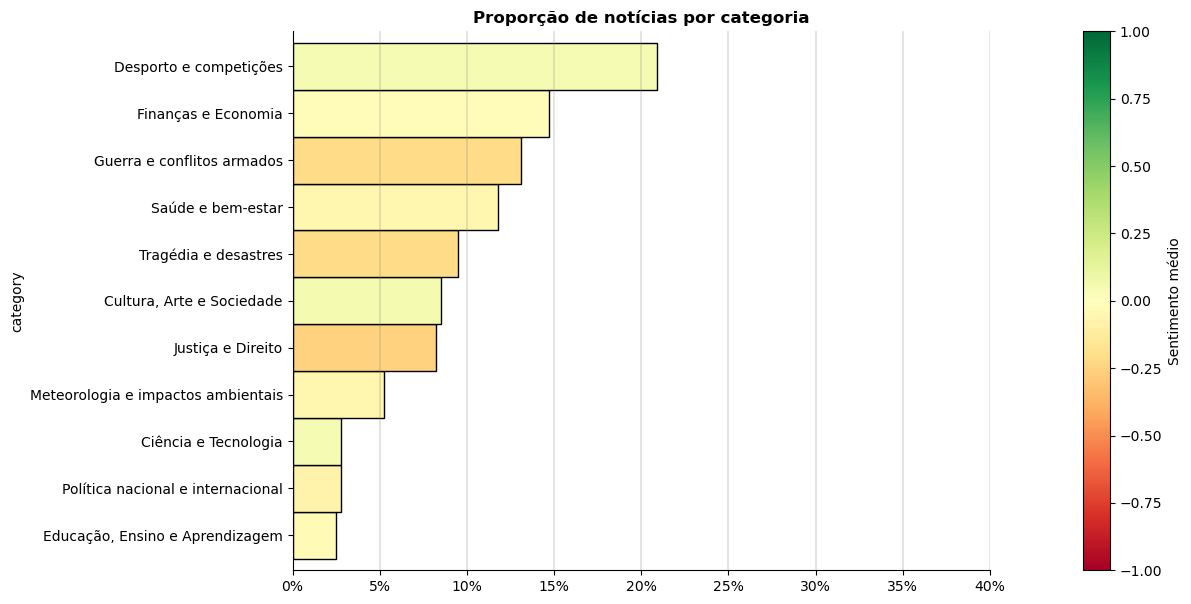

In [80]:
#Getting indexes aligned
proportions = news["category"].value_counts(normalize= True).sort_index()
are_news_that_negative_sorted = are_news_that_negative.sort_index()

#Creating a data frame where proportion per category and its average sentiment can be seen
are_news_that_negative_proportions = proportions.to_frame()
are_news_that_negative_proportions["sentiment"] = are_news_that_negative_sorted
are_news_that_negative_proportions.sort_values("proportion", ascending= True, inplace= True)

#Plotting proportion of news per category
ax = are_news_that_negative_proportions[:15].reset_index().plot(
    x = "category",
    y = "proportion",
    kind = "barh",
    color = colormap_rdylgn(are_news_that_negative_proportions["sentiment"])[0],
    figsize=(12, 7),
    width = 1,
    legend= "",
    edgecolor = "black",
    alpha = 1
    )
ax.set_title("Proporção de notícias por categoria", weight = "bold")
ax.set_xticks(
    ticks = [0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40], 
    labels = ["0%", "5%", "10%", "15%", "20%", "25%", "30%", "35%", "40%"]
    )
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.grid(False)
ax.grid(axis = "x", color= "gray", linestyle= "-", linewidth= 0.3)
cbar = plt.colorbar(colormap_rdylgn(are_news_that_negative_proportions["sentiment"])[1], orientation= "vertical", pad= 0.1, ax= ax)
cbar.set_label("Sentimento médio")
plt.savefig(proportion_per_category, format= "png", dpi = 600, bbox_inches = "tight")
plt.show()

#### Sentiment time series analysis

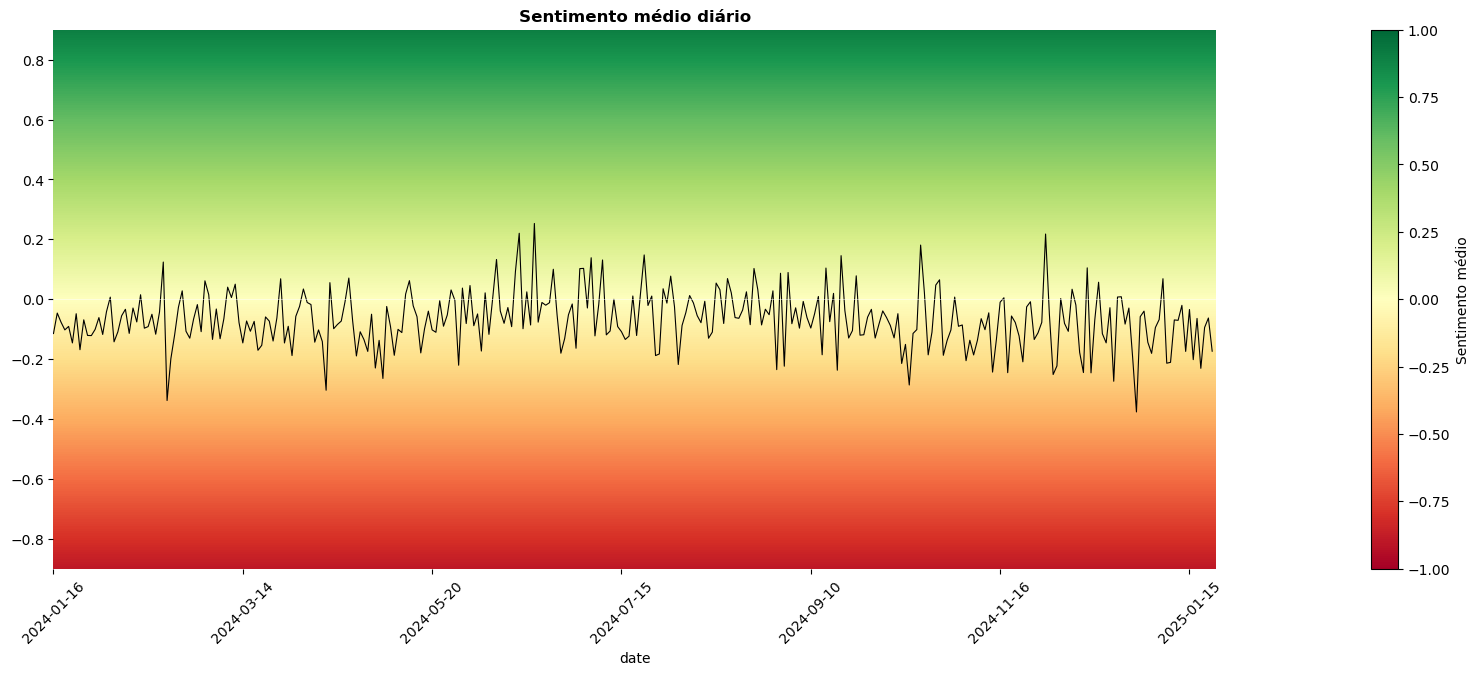

In [81]:
#Unbiased analysis by excluding the days that have less than 5 news
unbiased_news = news.groupby("date").filter(lambda x: len(x) > 5)

#Creating a copy of unbiased news to be used later
unbiased_news_copy = unbiased_news.copy()

#Finding average saily sentiment
avg_sentiment_per_day = unbiased_news.groupby("date")["sentiment"].mean()

#Plotting findings
fig, ax = plt.subplots(figsize=(20, 7))
avg_sentiment_per_day.plot(ax=ax, c = "black", linewidth = 0.8)
ax.set_title("Sentimento médio diário", weight="bold")
ax.set_ylim((-0.9, 0.9))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axhline(0, color = "white", linewidth = 0.7, alpha = 0.5)
cbar = plt.colorbar(colormap_rdylgn(are_news_that_negative_proportions["sentiment"])[1], orientation= "vertical", pad= 0.1, ax= ax)
cbar.set_label("Sentimento médio")
plt.xticks(rotation=45)

#Creating vertical gradient background
z = np.linspace(-0.9, 0.9, 10000)
z = np.vstack((z, z)).T
ax.imshow(z, aspect='auto', cmap=plt.cm.RdYlGn, extent=[0, len(avg_sentiment_per_day), 1, -1], alpha=1)

#Save the figure and show
plt.savefig(daily_sentiment, format="png", dpi=600, bbox_inches="tight")
plt.show()

In [82]:
#Converting date strings to datetime objects
unbiased_news["date"] = pd.to_datetime(unbiased_news["date"])

#Extracting the day of the week
unbiased_news["day_of_week"] = unbiased_news["date"].dt.day_name()

#Group news' sentiment by day ot the week
grouped_unbiased_news = unbiased_news.groupby("day_of_week")["sentiment"]

#Performing ANOVA test
anova_result = stats.f_oneway(
    grouped_unbiased_news.get_group("Monday"),
    grouped_unbiased_news.get_group("Tuesday"),
    grouped_unbiased_news.get_group("Wednesday"),
    grouped_unbiased_news.get_group("Thursday"),
    grouped_unbiased_news.get_group("Friday"),
    grouped_unbiased_news.get_group("Saturday"),
    grouped_unbiased_news.get_group("Sunday")
)

print("ANOVA Test Statistic:", anova_result.statistic)
print("p-value:", anova_result.pvalue)

#Check p_value for a standard 5% alpha
if anova_result.pvalue < 0.05:
    print("We reject the null hypothesis, the weekly seasonality is statistically significant.")
else:
    print("We don't reject the null hypothesis, there is no significant weekly seasonality detected.")

ANOVA Test Statistic: 3.5736156758787594
p-value: 0.0015380604634182198
We reject the null hypothesis, the weekly seasonality is statistically significant.


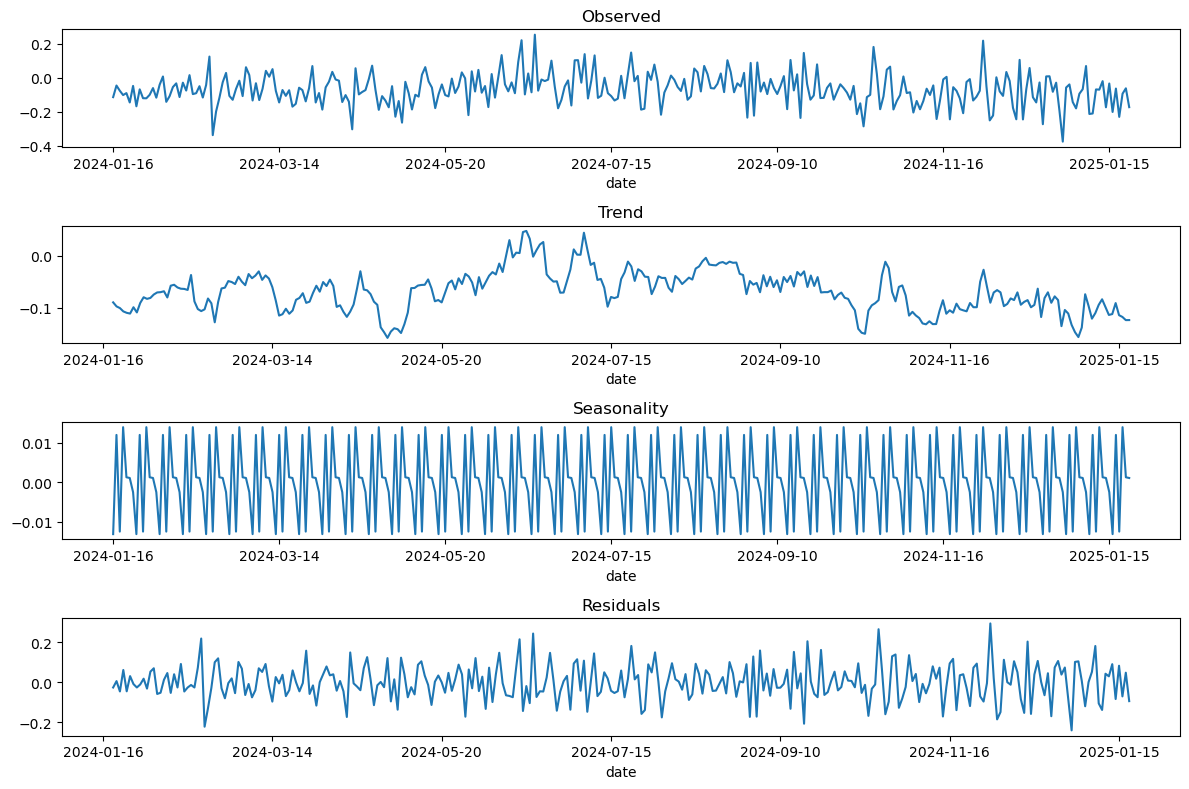

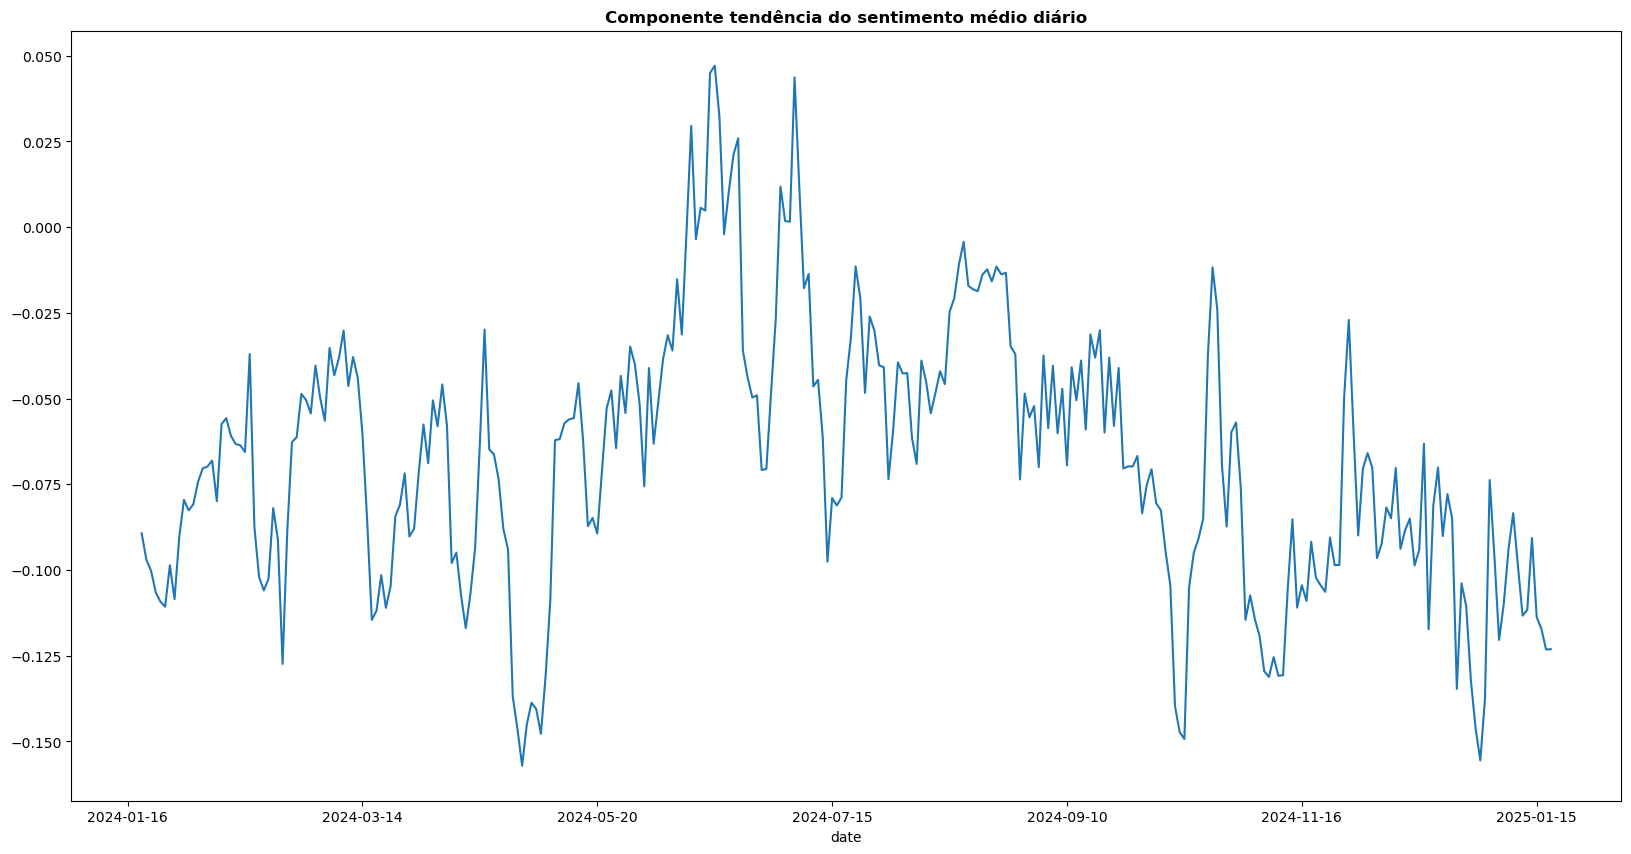

In [83]:
#Decompose time series into it's constituents
sentiment_ts_decomposition = seasonal_decompose(avg_sentiment_per_day, period=7)

#Plotting the desconstructed daily sentiment
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize = (12, 8))
sentiment_ts_decomposition.observed.plot(ax = ax1, title = "Observed")
sentiment_ts_decomposition.trend.plot(ax = ax2, title = "Trend")
sentiment_ts_decomposition.seasonal.plot(ax = ax3, title = "Seasonality")
sentiment_ts_decomposition.resid.plot(ax = ax4, title = "Residuals")
plt.tight_layout()
plt.show()

#Saving trend graph
fig, ax = plt.subplots(figsize = (20, 10))
sentiment_ts_decomposition.trend.plot(ax = ax)
ax.set_title("Componente tendência do sentimento médio diário", weight = "bold")
plt.savefig(output_average_sentiment_yearly_trend, format="png", dpi=600, bbox_inches="tight")

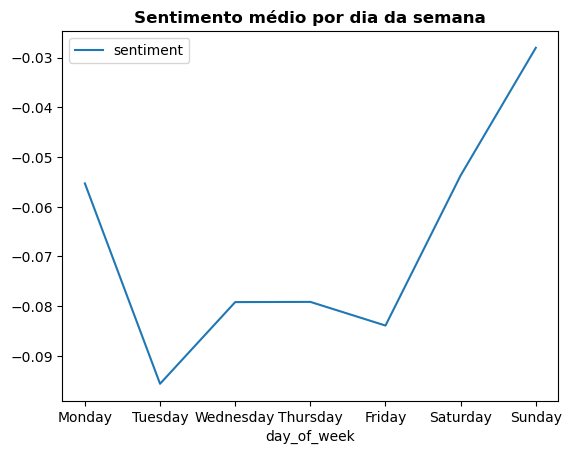

In [84]:
#Group news by day of the week using the mean
average_sentiment_per_day_of_week = grouped_unbiased_news.mean()
average_sentiment_per_day_of_week = average_sentiment_per_day_of_week.to_frame().reset_index()

#Creating an order from Monday to Sunday
day_of_week_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

#Change the day of the week to a Categorical variable that can be ordered
average_sentiment_per_day_of_week['day_of_week'] = pd.Categorical(
    average_sentiment_per_day_of_week['day_of_week'],
    categories = day_of_week_order,
    ordered=True
    )

#Order values per day of the week order
average_sentiment_per_day_of_week_sorted = average_sentiment_per_day_of_week.sort_values("day_of_week").set_index("day_of_week")

#Plotting the results
average_sentiment_per_day_of_week_sorted.plot()
plt.title("Sentimento médio por dia da semana", weight = "bold")
plt.savefig(day_of_week_average_sentiment, format="png", dpi=600, bbox_inches="tight")
plt.show()

#### Proportion of news about political parties and their average sentiment

In [85]:
#Relevant political parties in Portugal
political_parties = [
    (" AD ", "Aliança Democrática"),
    (" PS ", "Partido Socialista"),
    (" Chega ",),
    (" IL ", "Iniciativa Liberal"),
    (" BE ", " Bloco de Esquerda "),
    (" CDU ",),
    (" Livre ",),
    (" PAN ",),
    (" ADN ",)                          #Considered relevant due to possible vote mistakes
]

#Looping through news that contain party acronyms or/ and party names. Spaces were added on the acronyms to avoid false positives
average_sentiment = []
proportions = []
for party in political_parties:
    if len(party) == 2:
        description_sentiment = []
        quantities = []
        for description in party:
            selected_news = news[(news["title"].str.contains(description)) | (news["description"].str.contains(description))]
            description_sentiment.append(selected_news["sentiment"].values)
            quantities.append(len(selected_news))
        average_sentiment.append(np.mean(np.concatenate(description_sentiment).tolist()))
        proportions.append(np.sum(quantities))
    else:
        selected_news = news[(news["title"].str.contains(party[0])) | (news["description"].str.contains(party[0]))]
        average_sentiment.append(selected_news["sentiment"].mean())
        proportions.append(len(selected_news))
proportions = [100*proportion/np.sum(proportions) for proportion in proportions]         

#Creating DataFrame with average sentiment per party and their proportions
avg_sentiment_per_party = pd.DataFrame({"avg_sentiment": average_sentiment, "proportion": proportions}, index = [x[0] for x in political_parties])
avg_sentiment_per_party = avg_sentiment_per_party.sort_values("proportion", ascending = False) 

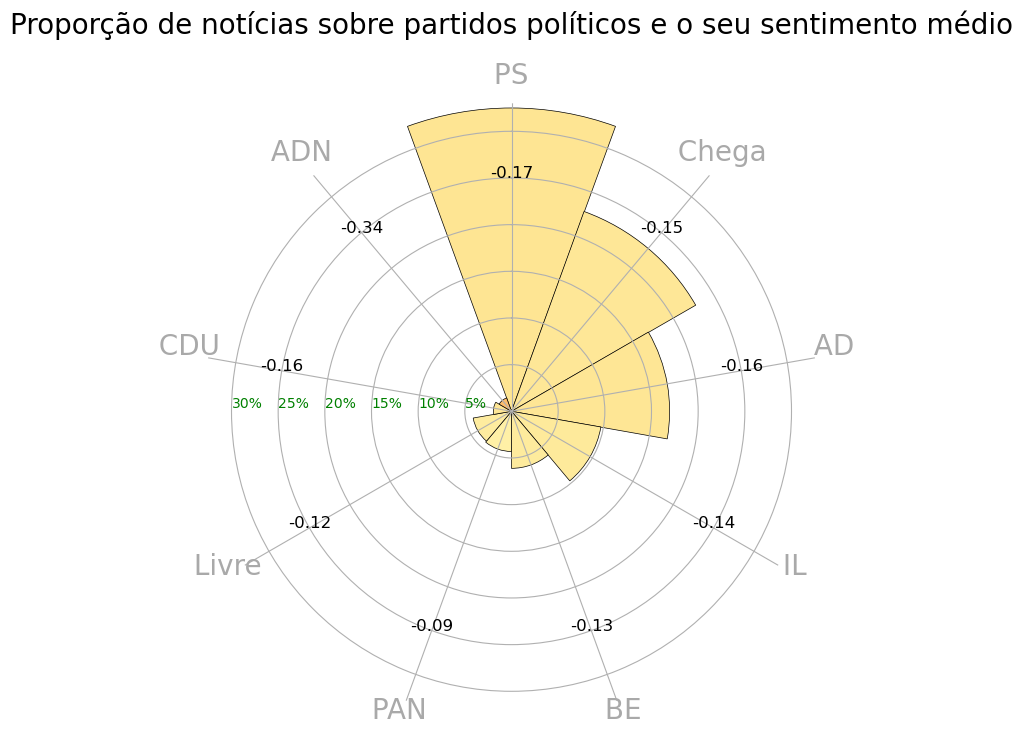

In [86]:
#Setting variables, figure and axis to plot findings
num_of_parties = len(avg_sentiment_per_party)
angles = np.linspace(0, 2 * np.pi, num_of_parties, endpoint=False).tolist()
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

#Rotate the plot so the first entry is on top and subsequent values "fade" clockwise
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

#Loop through values to draw bars
for sentiment, proportion, angle in zip(avg_sentiment_per_party.avg_sentiment, avg_sentiment_per_party.proportion, angles):
    ax.bar(
        angle,
        proportion,
        width=0.7,
        color=colormap_rdylgn(avg_sentiment_per_party.avg_sentiment, color_of_number = sentiment)[2],
        edgecolor='black',
        linewidth=0.5
        )
    ax.text(angle, 25, round(sentiment,2), horizontalalignment='center', size=12, color='black')


#Editing graph perks
ax.set_xticks(angles)
ax.set_xticklabels(avg_sentiment_per_party.index, color='darkgrey', size=20, fontdict = {"verticalalignment": "baseline"})
ax.set_rlabel_position(270)
ax.spines['polar'].set_visible(False)
plt.yticks([5, 10, 15, 20, 25, 30], ["5%", "10%", "15%", "20%", "25%", "30%"], color="green", size=10)
plt.ylim(0, 33)
plt.title('Proporção de notícias sobre partidos políticos e o seu sentimento médio', size=20, color='black', y=1.1)

#Save the figure and show
plt.savefig(political_party_sentiment, format="png", dpi=600, bbox_inches="tight")
plt.show()

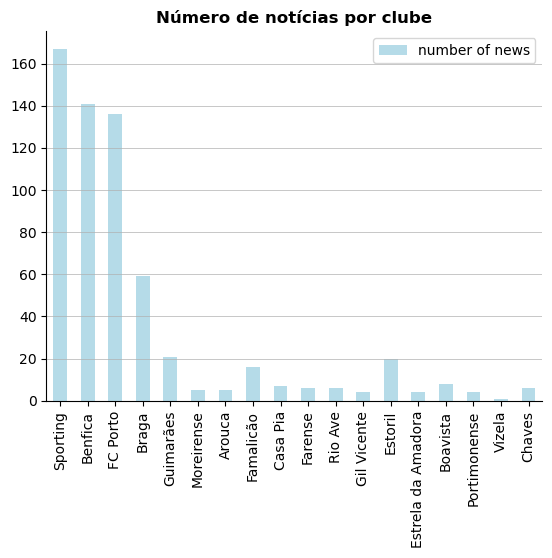

In [92]:
#Subsetting news to the Sports category
sports = news[news["category"] == "Desporto e competições"]

#First league clubs from 2023/2024 championship
clubs = [
    "Sporting",
    "Benfica",
    "FC Porto",
    "Braga",
    "Guimarães",
    "Moreirense",
    "Arouca",
    "Famalicão",
    "Casa Pia",
    "Farense",
    "Rio Ave",
    "Gil Vicente",
    "Estoril",
    "Estrela da Amadora",
    "Boavista",
    "Portimonense",
    "Vizela",
    "Chaves"
    ]

#Extracting the number of news per soccer club
news_about = []
for club in clubs:
    news_about.append(len(sports[sports['description'].str.contains(club)]))

#Building the dataframe of analysis
news_per_club = pd.DataFrame(data = news_about, index = clubs, columns = ["number of news"])

#Ploting results
ax = news_per_club.plot(kind = "bar", alpha = 0.9, color = "lightblue")
ax.yaxis.grid(True, linewidth = 0.5)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.title("Número de notícias por clube", weight="bold")

#Save the figure and show
plt.savefig(soccer_club_number_of_news, format="png", dpi=600, bbox_inches="tight")
plt.show()

In [88]:
news[news["category"] == "Desporto e competições"]

,date,category,title,description,title_tokens,description_tokens,sentiment
5,2024-01-16,Desporto e competições,AS Roma anuncia sucessor de José Mourinho,"O clube, que despediu esta terça-feira o técni...",AS Roma anuncia sucessor José Mourinho,"O clube, que despediu esta terça-feira o técni...",0.0000
11,2024-01-16,Desporto e competições,"""João Neves em dois dias ganhou o respeito do ...",O selecionador Roberto Martínez não escondeu a...,João Neves dias ganhou respeito balneário sele...,O selecionador Roberto Martínez não escondeu a...,0.2263
19,2024-01-16,Desporto e competições,Câmara de Lisboa abre concurso para criar músi...,A música oficial da 90.ª edição das Marchas Po...,Câmara Lisboa abre concurso criar música ofici...,A música oficial da 90.ª edição das Marchas Po...,0.0000
21,2024-01-16,Desporto e competições,Presidente do Palmeiras confirma: Abel Ferreir...,"No ""Verdão"" desde 2020, o treinador de 45 anos...",Presidente Palmeiras confirma Abel Ferreira re...,"No ""Verdão"" desde 2020, o treinador de 45 anos...",0.0000
23,2024-01-16,Desporto e competições,Sporting defende liderança em Vizela e Benfica...,"Na 18.ª jornada, a última antes da 'final four...",Sporting defende liderança Vizela Benfica tent...,"Na 18.ª jornada, a última antes da 'final four...",0.0000
...,...,...,...,...,...,...,...
11689,2025-01-21,Desporto e competições,Pedro Nuno e António Costa desafiam António Vi...,António Vitorino mantém o silêncio sobre uma c...,Pedro Nuno António Costa desafiam António Vito...,António Vitorino mantém o silêncio sobre uma c...,-0.1027
11691,2025-01-21,Desporto e competições,"""Deu tudo ao país"": Moedas apoia Marques Mende...",Carlos Moedas considera que há “uma pessoa que...,Deu país Moedas Marques Mendes Belém,Carlos Moedas considera que há “uma pessoa que...,0.3400
11697,2025-01-21,Desporto e competições,"Carragher arrasa Amorim: ""Das coisas mais biza...",O treinador português não vive um bom momento ...,Carragher arrasa Amorim Das coisas bizarras ri...,O treinador português não vive um bom momento ...,-0.7506
11700,2025-01-21,Desporto e competições,"Raphinha após a vitória sobre o Benfica: ""Houv...",Os 'encarnados' estiveram na frente do marcado...,Raphinha vitória Benfica Houve pessoas insulta...,Os 'encarnados' estiveram na frente do marcado...,-0.0772


#### Correlation with Lisbon weather data

In [89]:
#Window of analysis
weather_from = news.date.iloc[0]
weather_to = news.date.iloc[-1]

#Requesting weather data from weather.visualcrossing API     
try: 
  ResultBytes = urllib.request.urlopen(f"https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/Lisbon/{weather_from}/{weather_to}?unitGroup=us&include=days&key=4XT9UZXDG5BTW9XF3P3YDGXBM&contentType=csv")
  
  #Parse the results as CSV
  CSVText = csv.reader(codecs.iterdecode(ResultBytes, 'utf-8'))
  
  #Saving data in a csv file due to requests limit per day
  with open(dir + "Data/weather_data.csv", "w", newline = "", encoding = "utf-8") as csvfile:
    writer = csv.writer(csvfile)
    
    for row in CSVText:
      writer.writerow(row)
    
#Error handling
except urllib.error.HTTPError  as e:
  ErrorInfo= e.read().decode() 
  print('Error code: ', e.code, ErrorInfo)
  sys.exit()
except  urllib.error.URLError as e:
  ErrorInfo= e.read().decode() 
  print('Error code: ', e.code,ErrorInfo)
  sys.exit()

/var/folders/dp/s9mz34y92ys2kz2p9tmy9rp80000gn/T/ipykernel_17756/3734048150.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data.fillna(method = "bfill", inplace = True)


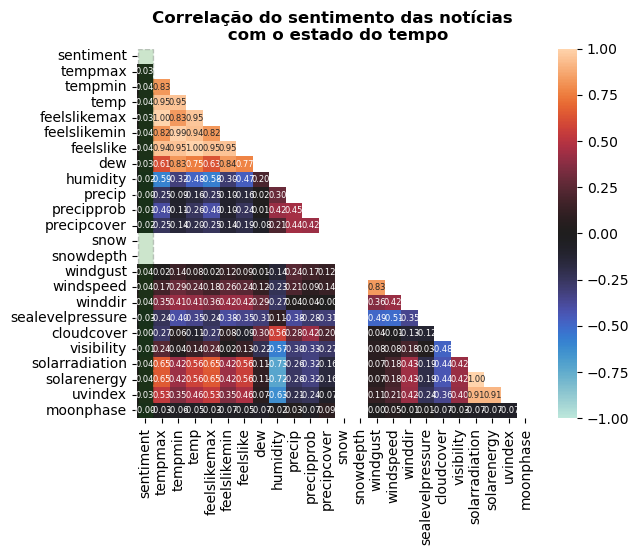

In [90]:
#Building the weather dataframe without nulls and categorical data - imputation of 2 missing records with backfill for minimum bias
weather_data = pd.read_csv(dir + "Data/weather_data.csv", index_col = "datetime")
weather_data.drop(["preciptype", "severerisk", "name", "stations", "description", "sunrise", "sunset", "conditions", "icon"], axis = 1, inplace = True)
weather_data.fillna(method = "bfill", inplace = True)
sentiment_data = unbiased_news_copy[["date", "sentiment"]].set_index(["date"])

#Analyzing correlation matrix
weather_correlation_analysis = sentiment_data.join(weather_data)
mask = np.triu(np.ones_like(weather_correlation_analysis.corr()))
sns.heatmap(weather_correlation_analysis.corr(), annot = True, vmax = 1, vmin = -1, center = 0, mask = mask, annot_kws= {"fontsize" : 6}, fmt=".2f")
plt.axvspan(xmin = 0.05, xmax = 1, color = "green", alpha = 0.2, ec = "black", ls = "--", lw = 1)
plt.title("Correlação do sentimento das notícias \n com o estado do tempo", weight = "bold")

#Save the figure and show
plt.savefig(correlation_with_weather, format="png", dpi=600, bbox_inches="tight")
plt.show()

#### Comparison between title and description mean sentiment

In [91]:
#Polarizing titles
unbiased_news_copy["title_sentiment"] = unbiased_news_copy["title"].apply(polarizer)

#Printing results
print("Description sentiment mean: ", unbiased_news_copy.sentiment.mean())
print("Title sentiment mean: ", unbiased_news_copy.title_sentiment.mean())

Description sentiment mean:  -0.06916381957773514
Title sentiment mean:  -0.0849203280404816


In [103]:
#Combined title and description mean and median
print("Combined mean of titles and descriptions: ",np.mean([unbiased_news_copy.sentiment.mean(), unbiased_news_copy.title_sentiment.mean()]))
print("Combined median of titles and desciprions: ",np.median([unbiased_news_copy.sentiment.median(), unbiased_news_copy.title_sentiment.median()]))

Combined mean of titles and descriptions:  -0.07704207380910837
Combined median of titles and desciprions:  0.0
